In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# pd.set_option('display.max_rows', None)

In [ ]:
train_data_path = '/content/drive/MyDrive/Carbon Dioxide Levels Prediction/train.csv'
test_data_path = '/content/drive/MyDrive/Carbon Dioxide Levels Prediction/test.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

#fill nan with 0
train_data = train_data.drop(['Indicator','Unit'],axis=1)
test_data = test_data.drop(['Indicator','Unit'],axis=1)
train_data['Value'] = train_data['Value'].fillna(0)

#fill outlier with 0
for i in range(len(train_data['Value'])):
  if train_data['Value'][i] > 600:
    train_data.loc[i, 'Value'] = 0

#month and year to date
def to_date(data):
  data['Date'] = data['Year'].astype(str) + '-' + data['Month']
  data['Date'] = pd.to_datetime(data['Date'],format = "%Y-%B")
  data = data.drop(['Year','Month'],axis=1)
  return data

train_data = to_date(train_data)
train_data = train_data[['Date','Value']]
test_data = to_date(test_data)

#sort the data
train_2 = train_data.sort_values(by=['Date'])
train_2.reset_index(drop=True,inplace=True)
test_2 = test_data #test data is already sorted

#fill missing values
for i in range(len(train_2['Value'])):
  if train_2['Value'][i] == 0:
    replacement = (train_2['Value'][i-1] + train_2['Value'][i+1]) / 2
    train_2.loc[i,'Value'] = replacement
length = len(train_2['Value'])

#pop date
a = train_2.pop('Date')
a = test_2.pop('Date')

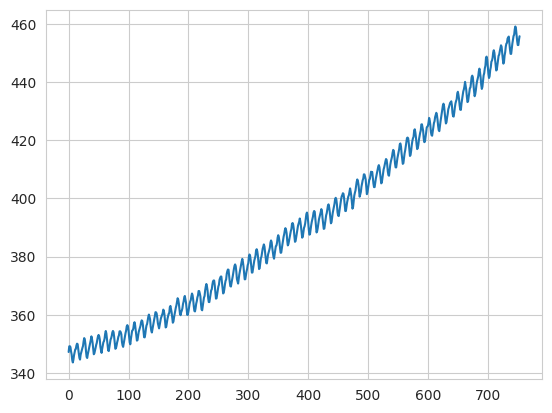

In [ ]:
plt.plot(train_2)

,target -26,target -25,target -24,target -23,target -22,target -21,target -20,target -19,target -18,target -17,...,target -9,target -8,target -7,target -6,target -5,target -4,target -3,target -2,target -1,Value
26,347.27,349.20,349.26,348.96,347.45,346.42,344.52,343.67,344.66,346.14,...,346.705,345.22,344.66,346.29,347.14,348.07,348.68,349.34,350.93,352.04
27,349.20,349.26,348.96,347.45,346.42,344.52,343.67,344.66,346.14,347.14,...,345.220,344.66,346.29,347.14,348.07,348.68,349.34,350.93,352.04,351.55
28,349.26,348.96,347.45,346.42,344.52,343.67,344.66,346.14,347.14,348.13,...,344.660,346.29,347.14,348.07,348.68,349.34,350.93,352.04,351.55,350.00
29,348.96,347.45,346.42,344.52,343.67,344.66,346.14,347.14,348.13,348.32,...,346.290,347.14,348.07,348.68,349.34,350.93,352.04,351.55,350.00,347.49
30,347.45,346.42,344.52,343.67,344.66,346.14,347.14,348.13,348.32,349.49,...,347.140,348.07,348.68,349.34,350.93,352.04,351.55,350.00,347.49,345.59


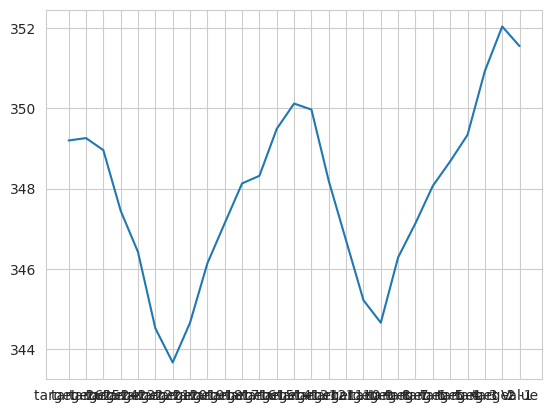

In [ ]:
target = 26

def add_targets(data):
  new_data = data.iloc[target:,:].copy()
  for i in range(target-1,-1,-1):
    new_data[f'target -{i+1}'] = data['Value'].shift(i+1)


  return new_data


train_3 = add_targets(train_2)
train_3['Value'] = train_3.pop('Value')
test_3 = test_2
plt.plot(train_3.iloc[1])
train_3.head()

(370, 27)

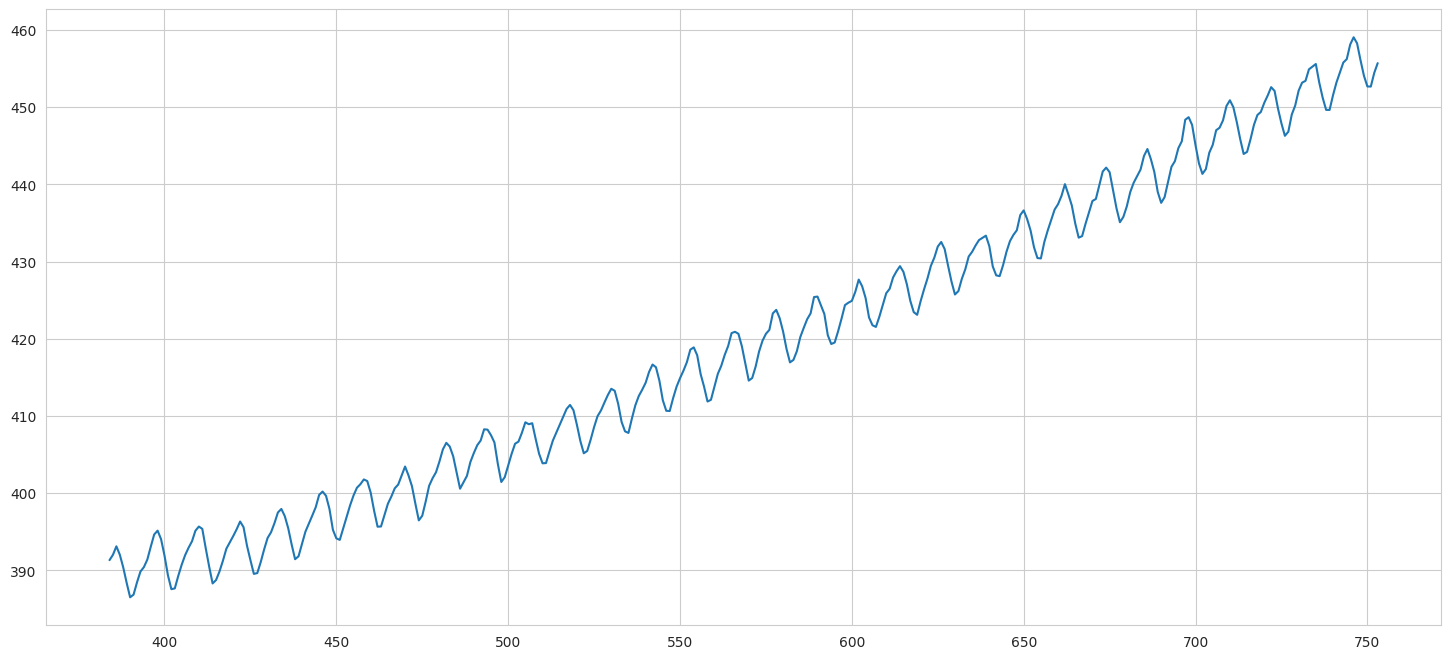

In [ ]:
train_3 = train_3.loc[384:,:]
plt.figure(figsize=(18,8))
plt.plot(train_3.iloc[:,-1])
train_3.shape

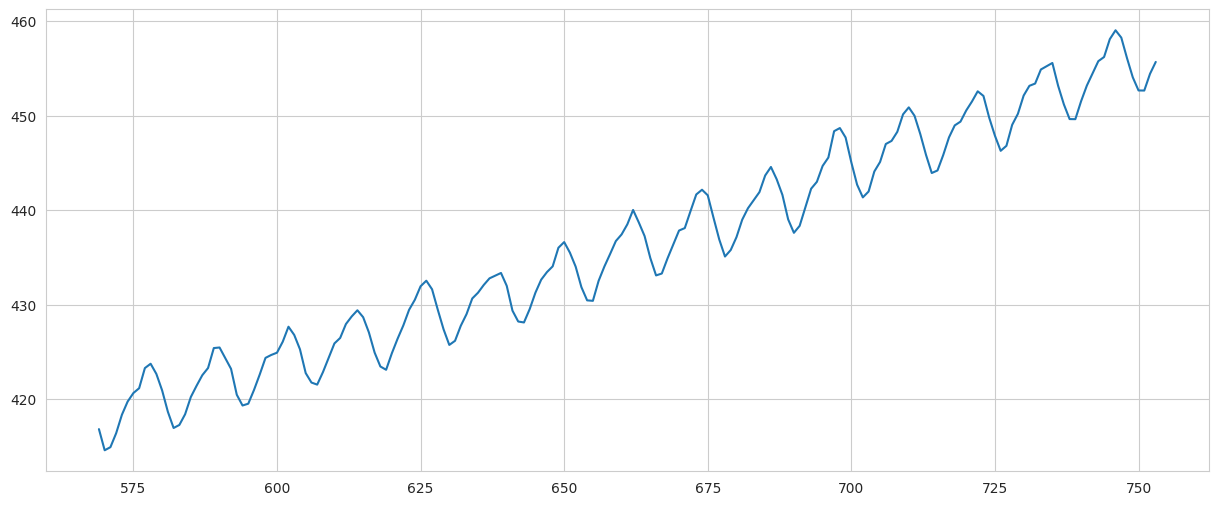

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_3.iloc[370//2:,-1])


In [ ]:
aug_n1 = train_3.iloc[len(train_3)//2:]
aug_n2 = train_3.iloc[len(train_3)* 3//4:]
n = train_3['Value'].loc[746] - train_3['Value'].loc[735]
print(n)
step = n/2

aug_n1 += step##-----------------
aug_n1_1 = aug_n1.copy()
aug_n1_1 -= 2*step##---------------

aug_n2 += (3*step)#------
aug_n3 = aug_n2.copy()
aug_n3 -= 6*step#----------
aug_n4 = aug_n3.copy()
aug_n4 += step#----------
aug_n5 = aug_n4.copy()
aug_n5 += step#----------
aug_n6 = aug_n5.copy()
aug_n6 += step#----------


3.4600000000000364


(1274, 27)

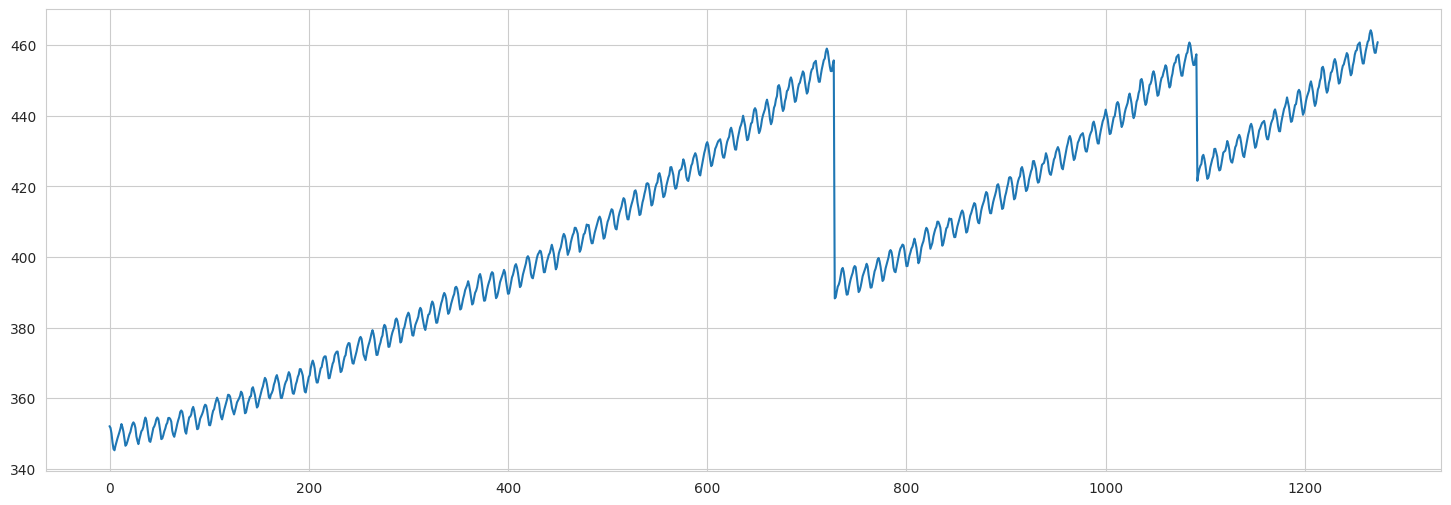

In [ ]:
aug_data = pd.concat([train_3, aug_n1, aug_n2], ignore_index=True)
plt.figure(figsize=(18,6))
plt.plot(aug_data ['Value'].iloc[:])
aug_data.shape

## normalise the data using z-Score
##### test_train2 -> z_train -> s_train

(1274, 27)

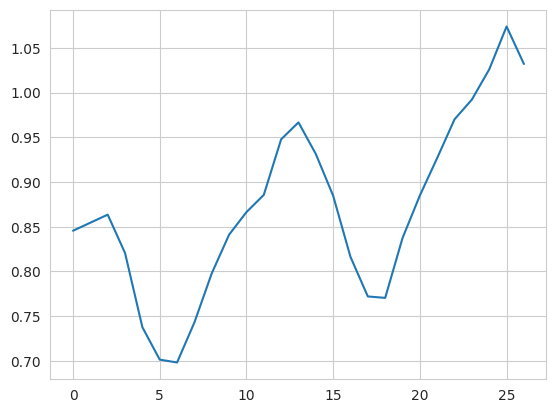

In [ ]:
data = aug_data.to_numpy()
data =  data.astype(np.float64)
type(data)

#normalization
mean_value = data.mean()
std_value = data.std()
train_4 = (data - mean_value) / std_value

train_4 = pd.DataFrame(train_4)
train_4.iloc[len(train_4)//2].plot()
train_4.shape

In [ ]:
train_4 = np.array(train_4)
type(train_4)

X = train_4[:,:-1]
x = X.reshape(X.shape[0], X.shape[1], 1)
y = train_4[:, -1]

x.shape, y.shape

((1274, 26, 1), (1274,))

### x,y -> x_train,y_train,  x_val,y_val

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)
print(f'out target size {target}')
x_train.shape,y_train.shape,x_val.shape,y_val.shape


out target size 26


((891, 26, 1), (891,), (383, 26, 1), (383,))

In [ ]:
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Multiply, Bidirectional, Dropout
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, LearningRateScheduler
# import numpy as np

# # Defineing a custom Attention layer
# class Attention(tf.keras.layers.Layer):
#     def _init_(self):
#         super(Attention, self)._init_()

#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
#         super(Attention, self).build(input_shape)

#     def call(self, x):
#         e = tf.matmul(x, self.W)
#         e = tf.tanh(e)
#         a = tf.nn.softmax(e, axis=1)
#         return a

# # Define the model with Attention and additional modifications
# inputs = Input(shape=(target, 1))
# lstm_out1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
# lstm_out12 = Bidirectional(LSTM(128, return_sequences=True))(lstm_out1)
# lstm_out2 = Bidirectional(LSTM(64, return_sequences=True))(lstm_out12)

# attention_weights = Attention()(lstm_out2)
# context_vector = Multiply()([lstm_out2, attention_weights])
# lstm_out3 = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)
# # dropout = Dropout(0.2)(lstm_out3)
# dense1 = Dense(64, activation='relu')(lstm_out3)
# dense2 = Dense(32, activation='relu')(dense1)
# output = Dense(1)(dense2)

# model = Model(inputs=inputs, outputs=output)


# model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

# # Learning rate scheduler to adjust the learning rate
# def lr_scheduler(epoch, lr):
#     if epoch % 20 == 0 and epoch:
#         lr = lr * 0.9
#     return lr

# lr_schedule = LearningRateScheduler(lr_scheduler)

# early_stopping = EarlyStopping(monitor='val_mse', patience=20, verbose=1, restore_best_weights=True)

In [ ]:
# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, callbacks=[early_stopping],verbose=2 )

In [ ]:
model = Sequential([layers.Input((target, 1)),
                    LSTM(32),
                    Dense(1)])


model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001),metrics=['mse'])


early_stopping = EarlyStopping( monitor='val_mse',  patience=20,  verbose=1, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500, callbacks=[early_stopping],verbose=2 )

Epoch 1/500
28/28 - 4s - loss: 0.3827 - mse: 0.3827 - val_loss: 0.3082 - val_mse: 0.3082 - 4s/epoch - 157ms/step
Epoch 2/500
28/28 - 0s - loss: 0.2648 - mse: 0.2648 - val_loss: 0.2065 - val_mse: 0.2065 - 377ms/epoch - 13ms/step
Epoch 3/500
28/28 - 0s - loss: 0.1707 - mse: 0.1707 - val_loss: 0.1259 - val_mse: 0.1259 - 353ms/epoch - 13ms/step
Epoch 4/500
28/28 - 0s - loss: 0.1009 - mse: 0.1009 - val_loss: 0.0714 - val_mse: 0.0714 - 380ms/epoch - 14ms/step
Epoch 5/500
28/28 - 0s - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0405 - val_mse: 0.0405 - 353ms/epoch - 13ms/step
Epoch 6/500
28/28 - 0s - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0270 - val_mse: 0.0270 - 362ms/epoch - 13ms/step
Epoch 7/500
28/28 - 0s - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0225 - val_mse: 0.0225 - 365ms/epoch - 13ms/step
Epoch 8/500
28/28 - 0s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0208 - val_mse: 0.0208 - 368ms/epoch - 13ms/step
Epoch 9/500
28/28 - 0s - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0195 - val_mse: 

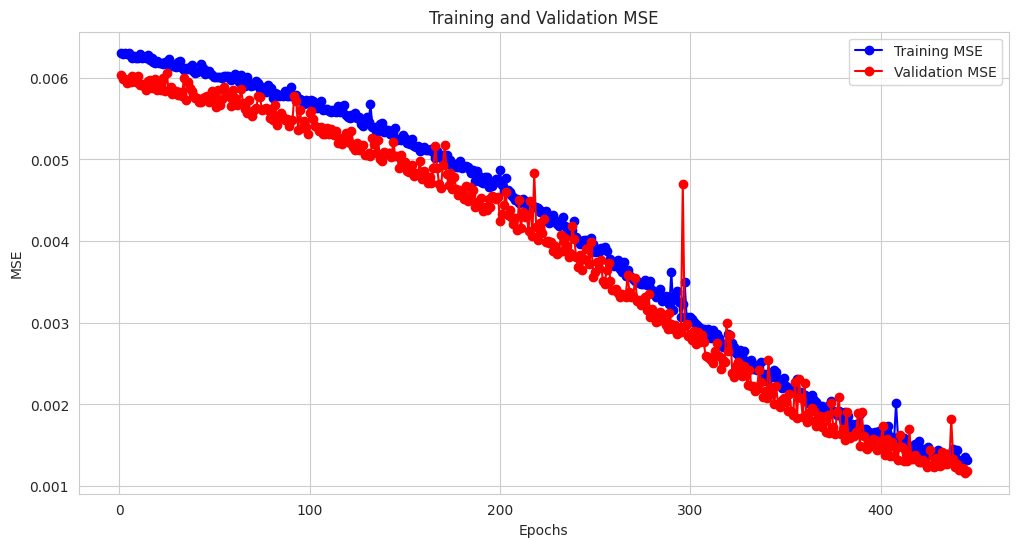

In [ ]:
mse = history.history['mse']
val_mse = history.history['val_mse']

# mse = mse[5:]
# val_mse = val_mse[5:]

mse = mse[55:]
val_mse = val_mse[55:]

# Create a plot
epochs = range(1, len(mse) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, mse, 'bo-', label='Training MSE')
plt.plot(epochs, val_mse, 'ro-', label='Validation MSE')

plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## predict new values

In [ ]:
pred_x = list(train_3.iloc[-1])
pred_x = np.array(pred_x)
pred_x = pred_x[1:]

pred_x = pred_x.astype(np.float64)
pred_x = (pred_x - mean_value) / std_value
pred_x = pred_x.reshape(1, len(pred_x), 1)
# print(pred_x)


In [ ]:
result =[]
for i in range(len(test_2)):

  ready = model.predict(pred_x)
  ready = ready.item()
  result.append(ready)

  pred_x = np.append(pred_x, ready)
  pred_x = pred_x[1:]
  pred_x = pred_x.reshape(1, len(pred_x), 1)


result = np.array(result) #24
result.shape

1/1 [==============================] - 0s 34ms/step


(24,)

In [ ]:
result_z = pd.DataFrame(result)
a = (train_3 - mean_value) / std_value
new_value = pd.concat([a['Value'], result_z ], axis=0, ignore_index=True)
len(train_3),len(new_value)

(728, 752)

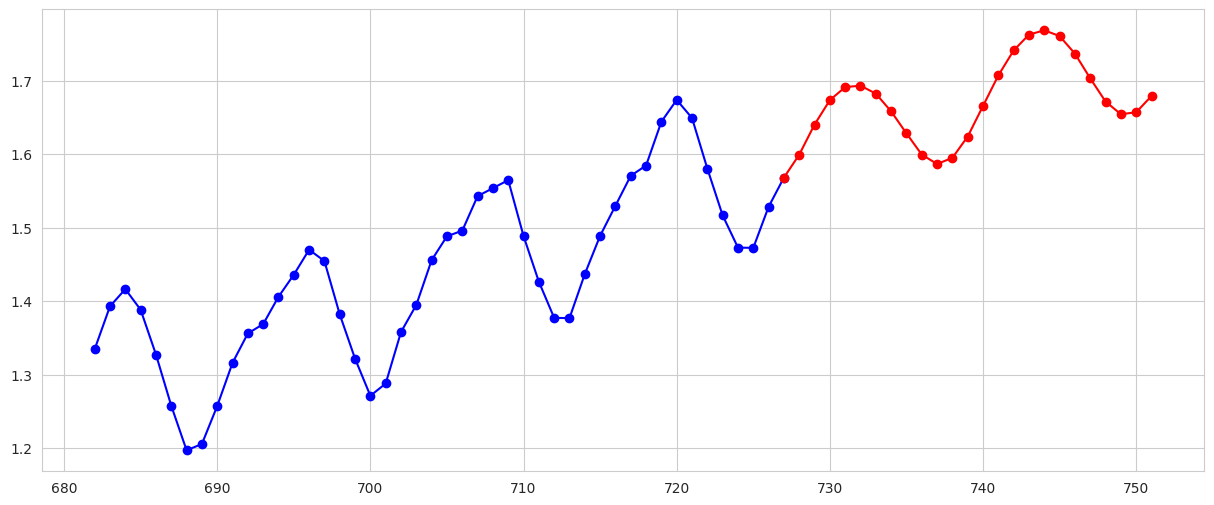

In [ ]:
new_value = pd.DataFrame(new_value)
plt.figure(figsize=(15,6))
plt.plot(new_value.iloc[len(new_value)-70:len(new_value)-24,:],'-bo')
plt.plot(new_value.iloc[len(new_value)-24 -1 :,:],'-ro')

,id,Label
0,0,456.678654
1,1,457.977301
2,2,459.031007
3,3,459.592938
4,4,459.653946


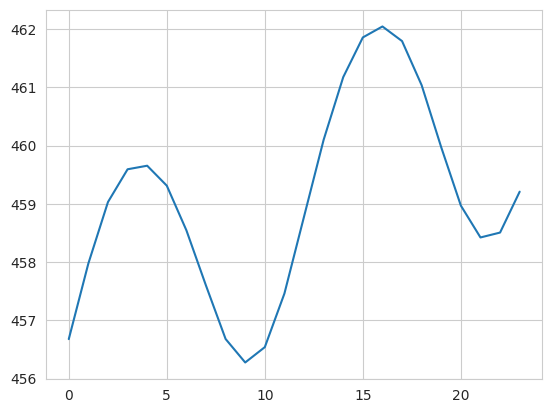

In [ ]:
test_2['Label'] =  result_z

test_2['Label'] = (test_2['Label'] * std_value) + mean_value
plt.plot(test_2['Label'])

test_2.head()

In [ ]:
test_2.to_csv('predictions.csv',index=False)
#result.to_csv('/content/drive/MyDrive/Player Transfer Value/final_Predictions_0.29.csv',index=False)